In [2]:
import numpy                as np
import matplotlib.pyplot    as plt
from astropy import units   as units
import sys
from matplotlib             import rcParams, rc


# Change the matplotlib default parameters
rcParams.update({'font.size':   8})
rcParams.update({'figure.dpi': 120})

sys.path.append('/lhome/silkem/ChemTorch/ChemTorch/')
from src.solve_n_save       import solve_dg
from src.input              import density
from src.datagen            import genSamples, next_input, get_dt, get_temp
import src.rates            as rates

rate = 16

outloc = '/lhome/silkem/ChemTorch/ChemTorch/out/'
samploc = '/lhome/silkem/ChemTorch/ChemTorch/sampling/'
dataloc = '/lhome/silkem/ChemTorch/PhantomSampling/'

### Getting sampling functions from Phantom distributions

In [23]:
def get_dist(nbins,file):
    data = np.loadtxt(dataloc+file+'.txt')
    out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)
    plt.title(file)
    plt.plot(out[1][:-1],out[0])
    # plt.xlim(-0.002, 0.0005)
    plt.show()
    return out


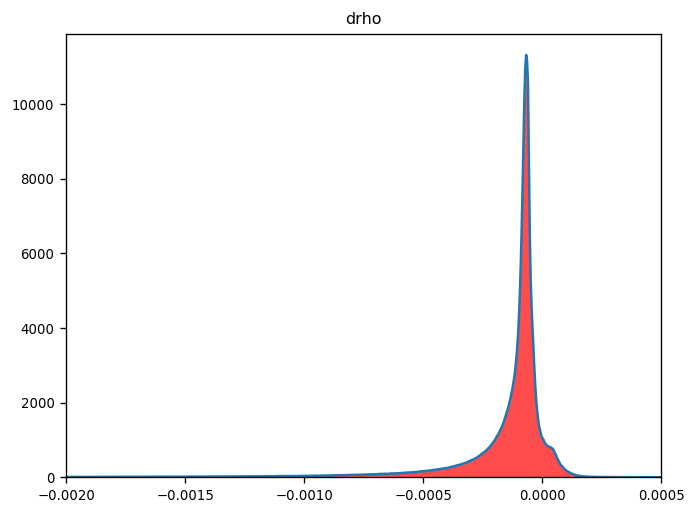

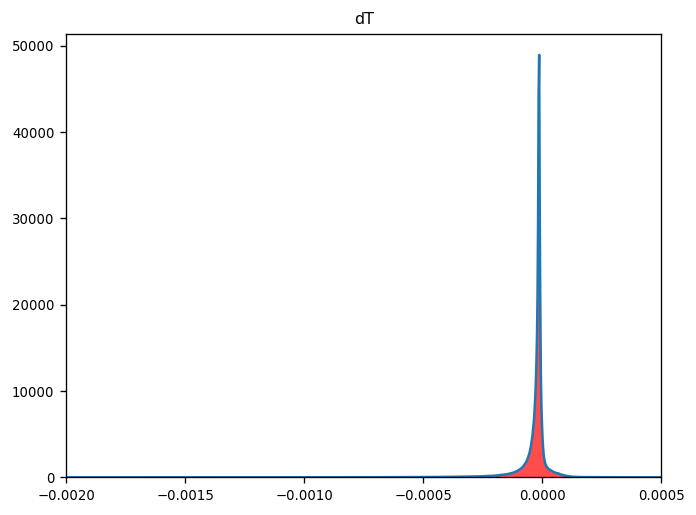

In [7]:
## diif density & temperature distributions

nbins = 100000
file = 'drho'
out_rho = get_dist(nbins, file)
file = 'dT'
out_temp = get_dist(nbins, file)


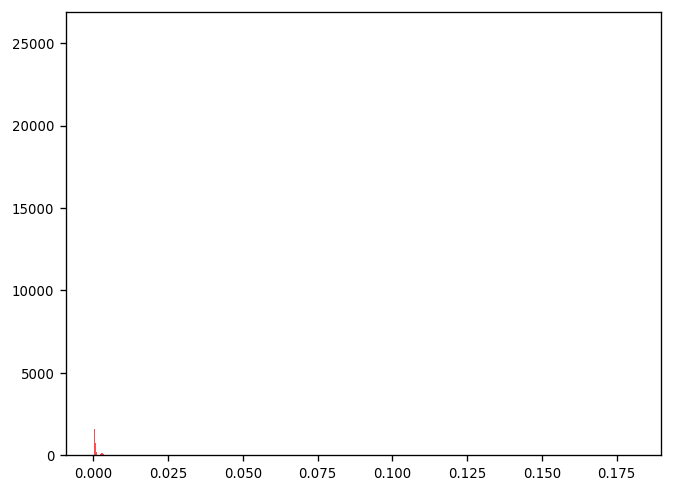

In [24]:
## dt distributions

nbins = 100000
dt1 = np.loadtxt(dataloc+'dtime1'+'.txt')
dt2 = np.loadtxt(dataloc+'dtime2'+'.txt')
dt3 = np.loadtxt(dataloc+'dtime3'+'.txt')
data = np.concatenate((dt1,dt2,dt3), axis = 0)  

# print(data.shape)

out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)


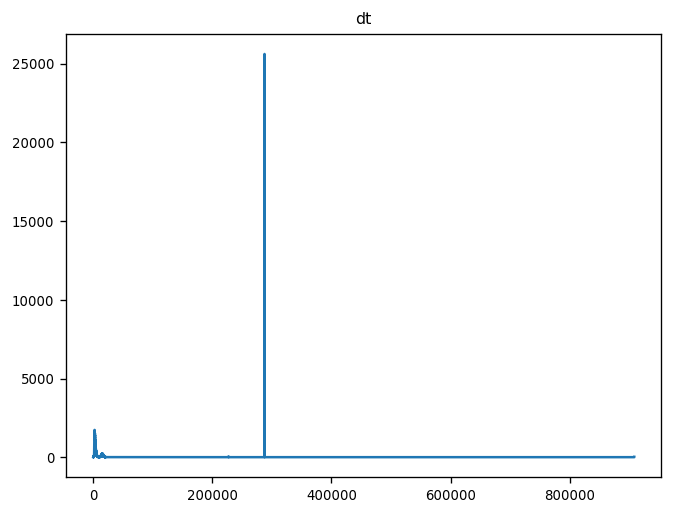

In [26]:
plt.title('dt')
plt.plot((out[1][:-1]*5022728.790082334),out[0])  ## because in PHANTOM code units ---> [sec]
# plt.xlim(-0.002, 0.075)
# plt.xscale('log')
plt.show()

In [27]:
np.save(samploc+'dtime', out[0])
np.save(samploc+'dtime_range', (out[1][:-1]*5022728.790082334)) 

In [11]:
np.save(samploc+'drho', out_rho[0]) 
np.save(samploc+'dT', out_temp[0]) 

In [16]:
np.save(samploc+'drho_range', out_rho[1][:-1]) 
np.save(samploc+'dT_range', out_temp[1][:-1]) 

### Data generation


In [8]:
# elke run eigen map, uniek, date ofzo
# checken op andere computer dat wanneer ge random seeds maakt, dat de random getallen effectief anders zijn
# nu enkel variaties van variabelen, begin met een gekozen input
# starten van de chemie waar ge mee eindigd --> paden in de fysiochemische ruimte
# eind abundantie terug meegeven, niet initialiseren

In [3]:
r = np.array(np.logspace(14,18, 100))
dens = density(1e-8, 5.,r )
temp = get_temp(3000,0.4, r) 

for i in range(len(dens)):
    chemtype = 'C'

    ## set initial conditions
    n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code

    δi  = 1.e-1
    Avi = -np.log(1.e-3)
    input = [dens[i],temp[i],δi,Avi]

    while input[0] > 10. and input[1] > 10.:
        Δt =  get_dt()    ## sec
        n = solve_dg(input, Δt, rate, n, nshield_i, nconsv_tot)
        input = next_input(input)

------------------------------------------------------------------------------
Name:
2023-08-08 05:10:58.212537

Input:
[density, temperature, delta, Av] dt:
[10.000001, 10.000001, 0.1, 6.907755278982137] 1915.52

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 1916.0 sec...
The solver successfully reached the end of the integration interval.
DONE! In 3.6 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-08 05:10:58.212537/
------------------------------------------------------------------------------


In [3]:


chemtype = 'C'

## set initial conditions
n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code

ρi  = 1.13E+05
Ti  = 2500
δi  = 1.e-1
Avi = -np.log(1.e-3)
input = [ρi,Ti,δi,Avi]

Δt =  get_dt()    ## sec

nf = solve_dg(input, Δt, rate, n, nshield_i, nconsv_tot)
    

------------------------------------------------------------------------------
Name:
2023-08-08 04:07:10.008115

Input:
[density, temperature, delta, Av] dt:
[113000.0, 2500, 0.1, 6.907755278982137] 16791.27

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 16791.0 sec...
The solver successfully reached the end of the integration interval.
DONE! In 4.34 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-08 04:07:10.008115/
------------------------------------------------------------------------------


In [6]:
input2 = next_input(input)
Δt =  genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec
nf2 = solve_dg(input2, Δt, rate, nf, nshield_i, nconsv_tot)

------------------------------------------------------------------------------
Name:
2023-08-07 03:02:26.609593

Input:
[density, temperature, delta, Av] dt:
[108708.12382570404, 2499.958409059154, 0.13435160756113276, 5.48212857761403] 5827.61

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 5828.0 sec...
The solver successfully reached the end of the integration interval.
DONE! In 4.23 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-07 03:02:26.609593/
------------------------------------------------------------------------------


[1.00807151e+01 1.00980299e+01 2.27700052e+00 9.87688629e-04
 4.04194189e+03]
[5.22431183 0.03579354]


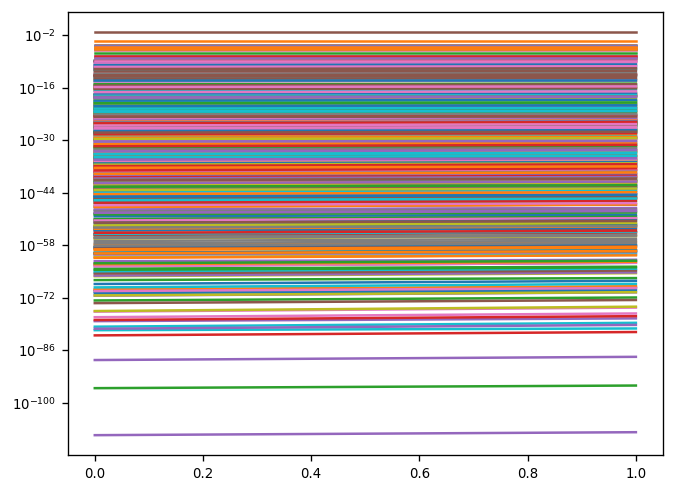

In [6]:

path = '/lhome/silkem/ChemTorch/ChemTorch/out/2023-08-08 04:57:28.735195/'

print(np.load(path+'input.npy'))
print(np.load(path+'tictoc.npy'))
# print(np.load(path+'abundances.npy'))
abs = np.load(path+'abundances.npy')

for i in range(abs.shape[0]):
    plt.plot(abs[i])

plt.yscale('log')